## Clustering de zonas según el peligro 
Para comenzar con este laboratorio, procedemos a importar las correspondientes librerías junto con los datasets. 

In [ ]:
# Librerías

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px
import itertools

# Cargamos el dataset
data = pd.read_csv('C:/Users/mbdia/Desktop/Laboratorio 3/Crimenes.csv')

# Damos print para visualizar nuestros datos
print(data.head())

       Estado  Asesinatos  Asaltos  Poblacion Urbana  Violaciones
0     Alabama        13.2      236                58         21.2
1      Alaska        10.0      263                48         44.5
2     Arizona         8.1      294                80         31.0
3    Arkansas         8.8      190                50         19.5
4  California         9.0      276                91         40.6


1. Análisis Descriptivo del Dataset:
* Generar histogramas para cada variable (asesinatos, asaltos, porcentaje de población urbana y violaciones) para analizar su distribución. 
* Crear gráficos de dispersión para observar correlaciones, como entre tasas de crimen y porcentaje de población urbana. 

In [7]:
# Definimos la ruta del archivo
path = r'C:/Users/mbdia/Desktop/Laboratorio 3/Crimenes.csv'
df_crimenes = pd.read_csv(path)

In [ ]:
#En este paso, visualizamos para ver los datos con los que vamos a trabajar

df_crimenes


In [ ]:
# Exploración inicial del dataset
df_crimenes.describe()
# Con esto pudimos observar que las variables tienen rangos amplios, lo que indica la necesidad de normalización

,Asesinatos,Asaltos,Poblacion Urbana,Violaciones
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [ ]:
# Eliminamos la columna "Estado" para trabajar únicamente con valores numéricos, ya que realizaremos un analisis de clustering
df_nostates = df_crimenes.drop(["Estado"], axis=1)

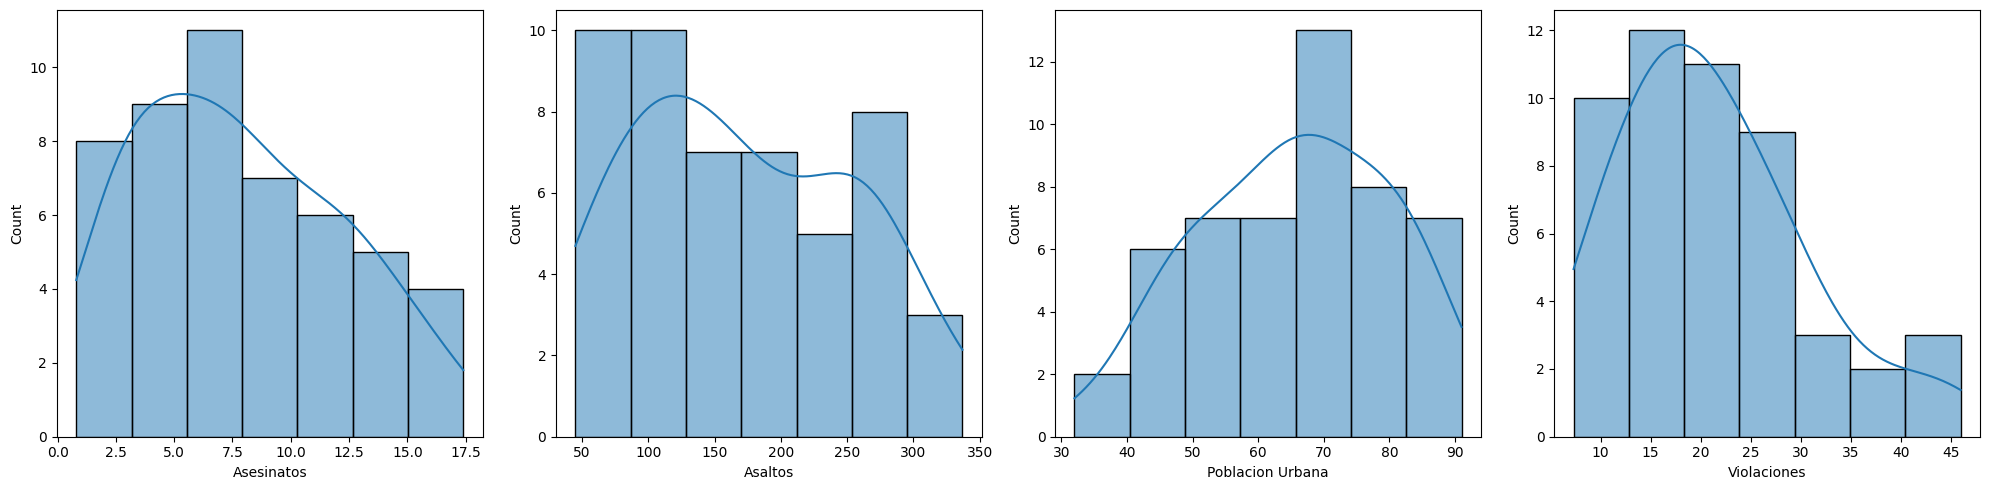

In [ ]:
# En esta parte generamos los histogramas para analizar la distribución de las variables
columns = df_nostates.columns
fig, axs = plt.subplots(1, len(columns), figsize=(5*len(columns), 5))

for i, column in enumerate(columns):
    sns.histplot(df_nostates[column], kde=True, ax=axs[i])  # Histogramas con KDE para ver distribucion
plt.tight_layout()
plt.show()

2. Selección y Preprocesamiento de Variables: 
* Normalizar o estandarizar las variables, analizar si es necesario este paso en un contexto de clustering (por ejemplo, para evitar que una variable con un rango alto domine el análisis).

In [ ]:
#Z-Score
#Primero buscamos los límites de outliers utilizando el Z-score. Esto lo utilizamos para identificar outliers en la columna "Violaciones"
upper_limit = df_nostates["Violaciones"].mean() + 3*df_nostates["Violaciones"].std()
lower_limit = df_nostates["Violaciones"].mean() - 3*df_nostates["Violaciones"].std()
print(upper_limit)
print(lower_limit)


49.33115359317894
-6.867153593178955


#En este caso notamos que Z-score resulta ineficaz, ya que como observamos, el límite máximo supera por bastante el número máximo dado en alguna columna, por lo que probaremos una tecnica mas robusta para detectar y eliminar los outliers.

In [34]:
#IQR
# En este paso, realizamos la identificación de outliers en "Violaciones" usando el método del rango intercuartil (IQR)

#Calculamos los cuartiles y el rango intercuartil (IQR)
Q1 = df_nostates["Violaciones"].quantile(0.25)
Q3 = df_nostates["Violaciones"].quantile(0.75)
IQR = Q3 - Q1

#Limites basados en los cuartiles
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(upper_limit)
print(lower_limit)


42.825
-1.5750000000000028


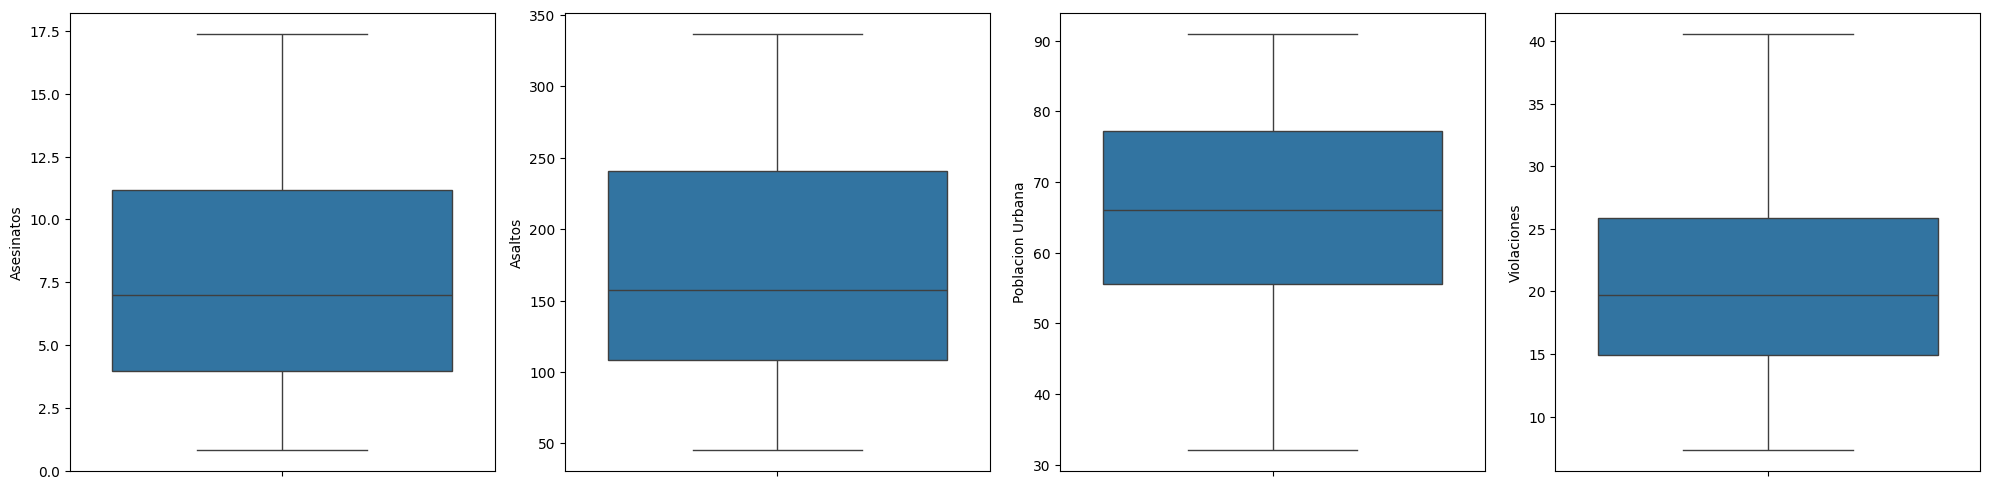

In [ ]:
# El limite de cuartiles actua como una mascara que elimina los datos que sean superiores a Upper_limit e inferiores a lower_limit.
# Creamos un nuevo dataset sin outliers
new_df_nostates = df_nostates.loc[
    (df_nostates["Violaciones"] >= lower_limit) & 
    (df_nostates["Violaciones"] <= upper_limit)
]

#Graficamos 
fig, axs = plt.subplots(1, len(columns), figsize=(5*len(columns), 5))

for i, column in enumerate(columns):
    sns.boxplot(y=column, data=new_df_nostates, ax=axs[i])

plt.tight_layout()
plt.show()

En el grafico se puede ver la diferencia en el grafico de Violaciones. Ahora sin outliers en "Violaciones"

3. Aplicación del Método de Clustering: 
* Elegir un algoritmo de clustering (como K-means o DBSCAN). Explicar la elección del modelo. 
* Determinar los parámetros del modelo (como el número de clusters en K-means) usando técnicas como el método del codo o el coeficiente de silueta para optimización.

#En este caso decidimos utilizar: K-means

In [ ]:
# Normalizamos los datos al rango [0, 1]
df_crimenes_norm = (new_df_nostates - new_df_nostates.min()) / (new_df_nostates.max() - new_df_nostates.min())

Normalizamos los datos para que todos estuvieran en un rango de 0 a 1. Esto ayuda a que K-Means no se vea influenciado por valores atípicos con magnitudes altas, mejorando tanto la eficiencia del algoritmo como la interpretación de los resultados

Para este análisis, elegimos Partitioning Clustering. Determinar el número óptimo de clusters es uno de los pasos más complejos, y usaremos la técnica del Codo para definirlo, ya que no hay un único método correcto

Como mencionamos anteriormente, elegimos el algoritmo K-Means, ya que es intuitivo y tiene una implementacion sencilla. En el caso de este analisis, los datos proporcionados tienen una estructura clara con clusters concretos y nos parecio buena idea esta eleccion por sobre otra.

In [ ]:
#Realizamos el uso del método del codo para determinar el número óptimo de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init='auto')
    kmeans.fit(df_crimenes_norm)
    wcss.append(kmeans.inertia_)

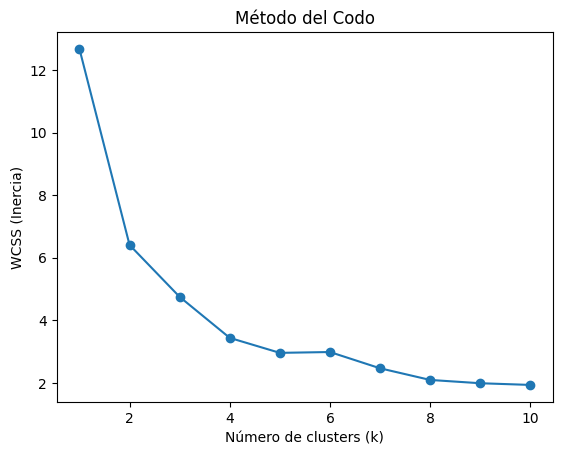

In [ ]:
# Graficamos
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número optimo de clusters (k)")
plt.ylabel("WCSS)")
plt.show()

Determinar el número óptimo de clústeres es uno de los aspectos más complicados en clustering, especialmente en partitioning clustering, donde el número debe definirse antes de ver los resultados. Para este caso, utilizamos la técnica del Codo, que nos ayudó a identificar que 4 clústeres es una buena opción. Al comparar la inercia, pudimos apreciar que con 3 clústeres la inercia era considerablemente mayor que con 4. Aunque la inercia siempre disminuye al aumentar k, el salto entre 3 y 4 fue significativo, pasando de 5 puntos a 3.69, lo que confirma que 4 es un buen número de clústeres. Además, graficar la inercia en cada caso facilita la elección de la cantidad adecuada de centroides.

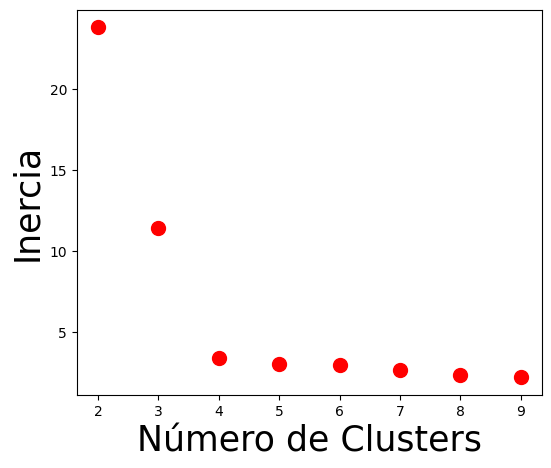

In [ ]:
# Gráfico de inercia. Esto nos confirma en numero optimo de clusters, ya que nos muestra como la inercia dsiminuye a medida que aumenta el numero de clusters. 
inercia = []

for k in range(2,10):
  kmeans = KMeans(n_clusters = k, n_init='auto').fit(df_crimenes_norm.values)
  inercia.append(kmeans.inertia_)

plt.figure(figsize=(6,5), dpi=100)
plt.scatter(range(2,10), inercia, marker="o", s=100, color="red")
plt.xlabel("Número de Clusters", fontsize=25)
plt.ylabel("Inercia", fontsize=25)
plt.show()


En este gráfico, oberservamos que la inercia sigue un patrón similar al gráfico anterior, disminuyendo a medida que aumenta el número de centroides.

In [37]:
# Finalmente, determinamos el número de clusters, que en este caso es 4, y entrenamos el modelo K-means
#Modelo de clusters optimo
kmeans_final = KMeans(n_clusters=4, max_iter=300, n_init='auto')
#Asignamos etiquetas a los clusters del dataset
kmeans_final.fit(df_crimenes_norm)

KMeans(n_clusters=4)

4. Interpretación de Resultados y Validación del Modelo: 
* Interpretar los clusters y verificar si representan zonas de "alta" y "baja peligrosidad". Explicar qué representa cada cluster y la calidad de la agrupación basada en las métricas.

In [ ]:
for crimen in columns:
  fig = px.box(df_crimenes_norm, x="KMeans Clusters", y=crimen)
  fig.show()

En este gráfico oberservamos cómo se distribuyen los clusters en relación con los delitos: Asaltos, Violaciones y Asesinatos. Los clusters 1 y 3 muestran los niveles más altos de criminalidad, lo que sugiere que representan las zonas más peligrosas, mientras que los clusters 0 y 2 corresponden a áreas más seguras.

Clasificación de los clusters:

Más seguro: Cluster 2
Seguro: Cluster 0
Inseguro: Cluster 3
Más inseguro: Cluster 1


C:\Users\mbdia\AppData\Local\Temp\ipykernel_9592\4077891058.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



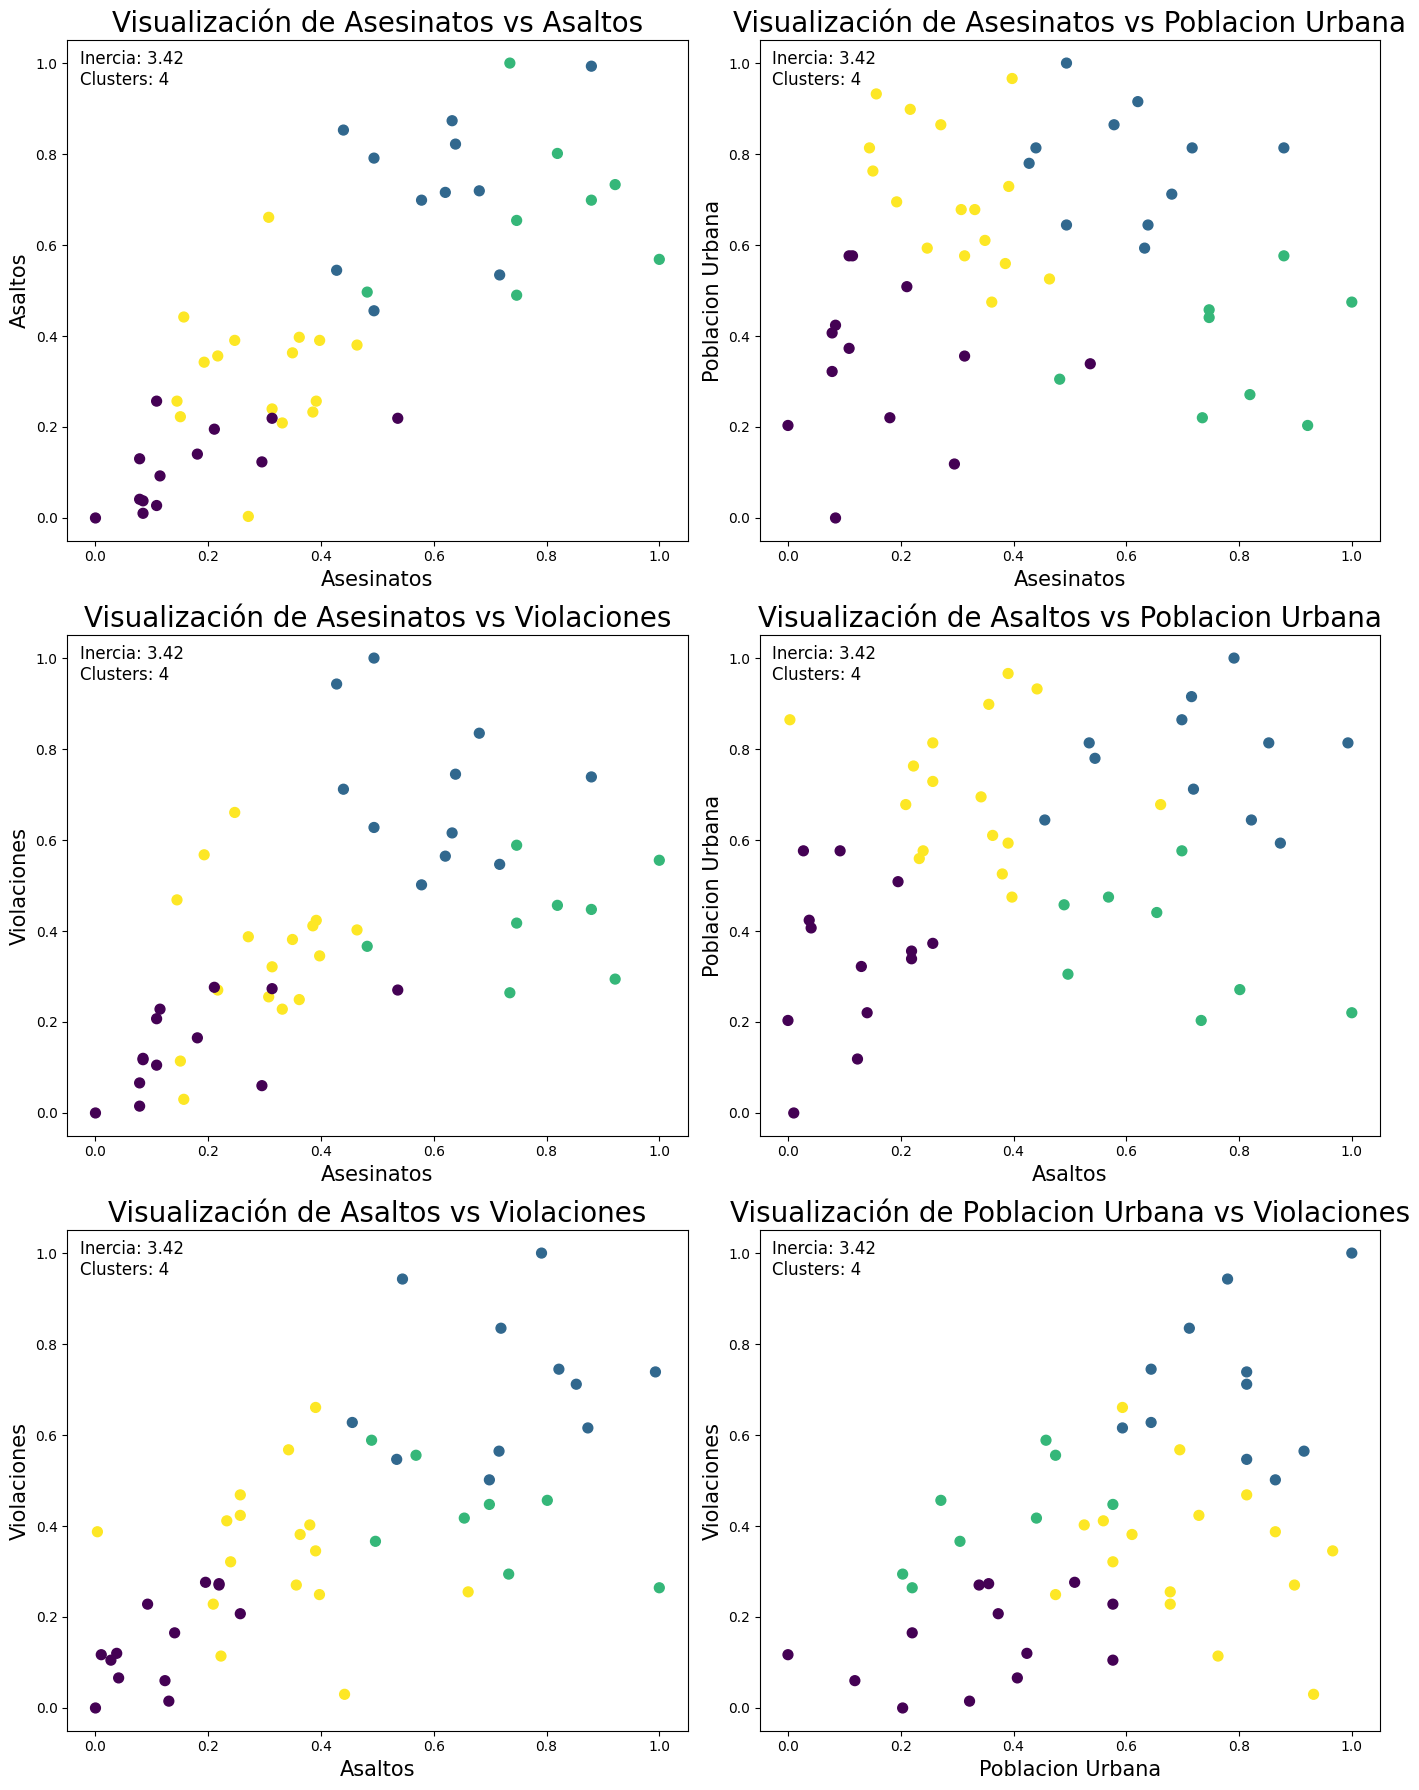

In [50]:
# Ajustamos el modelo
df_crimenes_norm['KMeans Clusters'] = kmeans.fit_predict(df_crimenes_norm[columns])

# Visualización de clusters en diferentes combinaciones de variables
combinaciones = list(itertools.combinations(columns, 2))
n = len(combinaciones)
cols = 2
rows = math.ceil(n / cols)

# Cremos la figura y los subgráficos
fig, axs = plt.subplots(rows, cols, figsize=(14, 6 * rows))
colors = plt.cm.get_cmap('viridis', kmeans.n_clusters)

# Iteramos sobre las combinaciones de variables y graficamos
for i, combinacion in enumerate(combinaciones):
    x, y = combinacion
    ax = axs[i // cols, i % cols]
    ax.set_xlabel(x, fontsize=15)
    ax.set_ylabel(y, fontsize=15)
    ax.set_title(f"Visualización de {x} vs {y}", fontsize=20)

    scatter = ax.scatter(df_crimenes_norm[x], df_crimenes_norm[y], c=df_crimenes_norm["KMeans Clusters"], cmap=colors, s=50)
    # Agregamos el valor de la inercia y la cantidad de clusters al gráfico
    ax.text(0.02, 0.98, f'Inercia: {kmeans.inertia_:.2f}\nClusters: {kmeans.n_clusters}', transform=ax.transAxes, fontsize=12, verticalalignment='top', color='black')


plt.tight_layout()
plt.show()

En este gráfico podemos observar visualmente la separación de los datos en 4 grupos con 4 centroides, a pesar de algunos outliers que persisten (incluso después de eliminar los valores atípicos de "Violaciones"). La cantidad de graficos se debe a que quisimos analizar todos los casos posibles.

5. Conclusiones

* A partir del análisis de clustering, hicimos una pequena investigacion sobre que podiamos esperar en cuanto a niveles de peligrosidad en relacion a las regiones de este pais. Pudimos identificar distintas zonas con características variadas en cuanto a peligrosidad, tomando en cuenta factores como los crímenes violentos y su distribución geográfica. Aunque los resultados no coincidieron completamente con la idea inicial que teníamos sobre la peligrosidad de ciertas regiones de EE.UU. , los clusters lograron proporcionar una visión interesante sobre cómo se agrupan los patrones de criminalidad.
* En particular, algunas zonas tradicionalmente consideradas más peligrosas, como ciertos estados del sur, no se agruparon como esperabamos, lo cual puede deberse a la presencia de valores atípicos (por ejemplo, las altas tasas de violaciones en algunas áreas). A pesar de eso, los clusters parecen tener una separación razonable, lo que indica que, aunque hay algunas áreas con superposición, los grupos son relativamente consistentes. 